# ARIMA Example

## To add a heading:
- Insert a new cell
- Type or paste-in content
- Place a single / just one "pound-sign" in front of the heading content
- Select "Markdown"
- Press "Shift", "Enter" at same time to convert to clean commentary

## To add a sub-heading:
- Insert a new cell
- Type or paste-in content
- Place two "pound-signs" in front of the sub-heading
- Select "Markdown"
- Press "Shift", "Enter" at same time to convert to clean commentary

## To add new bulleted documentation:

- Insert a new cell
- Type or paste-in content
- Place a "dash" character in front of the bulleted content
- Select "Markdown"
- Press "Shift", "Enter" at same time to convert to clean commentary

## References
- http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
- https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
- http://people.duke.edu/~rnau/whatuse.htm
- http://people.duke.edu/~rnau/arimrule.htm

## Import Libraries

In [66]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

#Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

#Seasonal Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

#ACF and PACF Functions:
from statsmodels.tsa.stattools import acf, pacf

#Date management tools
from pandas.core import datetools

#ARIMA model
from statsmodels.tsa.arima_model import ARIMA

import matplotlib.pylab as plt
import matplotlib as mpl
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6


# Helper Functions
## Function: test_stationarity(name of time series)

In [61]:
def test_stationarity(timeseries):
    #determine rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(window=12,center=False).mean()
    #rolstd  = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(window=12,center=False).std()
    
    #Plot Rolling Stats
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std  = plt.plot(rolstd, color='black', label='Rolling StdDev')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Std Deviation')
    plt.show(block=False)
    
    #Perform Dickey Fuller Test
    print('Results of Dickey-Fuller Test')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

def seasonal_decomposition(timeseries):
    decomposition = seasonal_decompose(timeseries.dropna(inplace=False))

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='best')
    plt.tight_layout()

def acf_pacf_plot(timeseries):
    lag_acf = acf(timeseries, nlags=20)
    lag_pacf = pacf(timeseries, nlags=20, method='ols')

    #Plot ACF:
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()



In [35]:
data = pd.read_csv('C://Users//a1000391//Desktop//timeseries.csv')
#data = pd.read_csv('C://Users//a1000391//Desktop//AirPassengers.csv')
print(data.head())
print('/n Data Types:')
print(data.dtypes)
data.index

         Date   ts
0  2013-02-03  226
1  2013-02-10  141
2  2013-02-17  222
3  2013-02-24  257
4  2013-03-03  216
/n Data Types:
Date    object
ts       int64
dtype: object


RangeIndex(start=0, stop=318, step=1)

## Reset the dataframe index to be the Date

In [36]:
data["Date"] = pd.to_datetime(data["Date"])
data.set_index(["Date"], drop=True, append=False, inplace=True, verify_integrity=True)

## Confirm Date is now the index for the dataframe

In [37]:
print(data.head)
print('\n Data Types:')
print(data.dtypes)
print(data.index)

<bound method NDFrame.head of              ts
Date           
2013-02-03  226
2013-02-10  141
2013-02-17  222
2013-02-24  257
2013-03-03  216
2013-03-10  263
2013-03-17  222
2013-03-24  157
2013-03-31  263
2013-04-07  168
2013-04-14  130
2013-04-21  222
2013-04-28  276
2013-05-05  274
2013-05-12  285
2013-05-19  258
2013-05-26  271
2013-06-02  303
2013-06-09  250
2013-06-16  301
2013-06-23  290
2013-06-30  310
2013-07-07  239
2013-07-14  188
2013-07-21  255
2013-07-28  311
2013-08-04  292
2013-08-11  312
2013-08-18  333
2013-08-25  326
...         ...
2018-08-12  778
2018-08-19  847
2018-08-26  824
2018-09-02  802
2018-09-09  826
2018-09-16  782
2018-09-23  818
2018-09-30  819
2018-10-07  807
2018-10-14  811
2018-10-21  716
2018-10-28  833
2018-11-04  813
2018-11-11  728
2018-11-18  727
2018-11-25  793
2018-12-02  787
2018-12-09  784
2018-12-16  796
2018-12-23  792
2018-12-30  853
2019-01-06  799
2019-01-13  764
2019-01-20  849
2019-01-27  876
2019-02-03  856
2019-02-10  817
2019-02-17

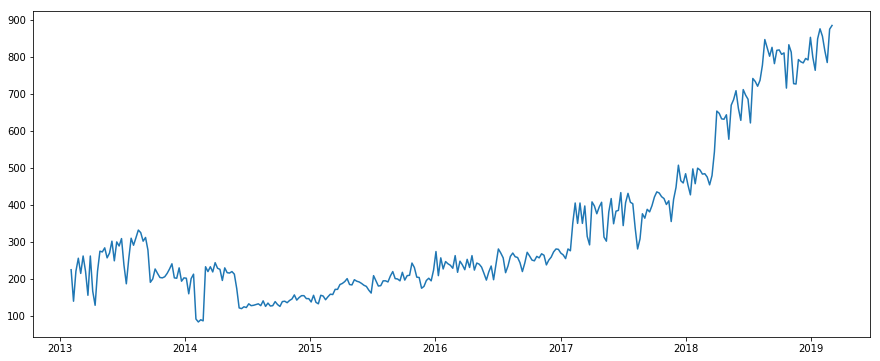

In [38]:
plt.plot(data.ts)

## Test time series for Stationarity (unit roots)

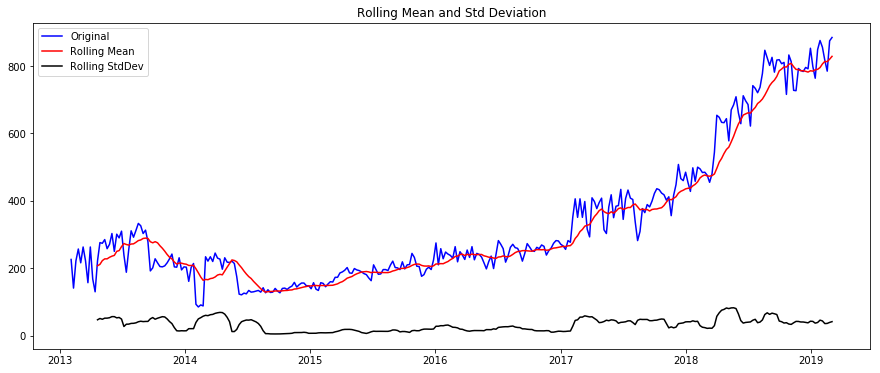

Results of Dickey-Fuller Test
Test Statistic                   1.899241
p-value                          0.998527
#Lags Used                       7.000000
Number of Observations Used    310.000000
Critical Value (1%)             -3.451622
Critical Value (5%)             -2.870909
Critical Value (10%)            -2.571762
dtype: float64


In [41]:
test_stationarity(data.ts)

## Stationarity Tests - First Difference

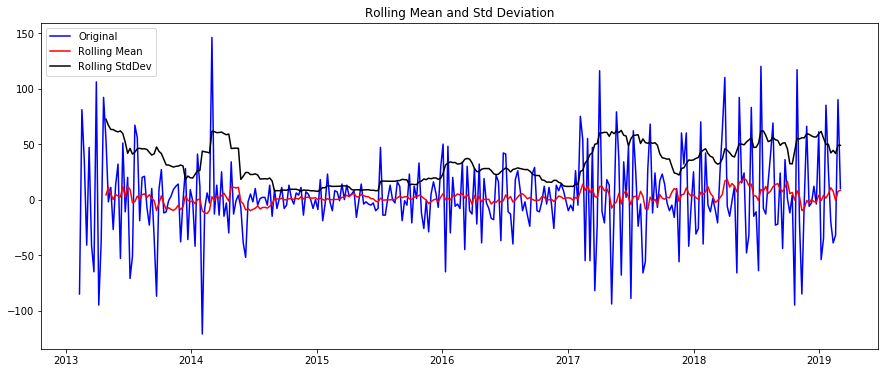

Results of Dickey-Fuller Test
Test Statistic                -9.563416e+00
p-value                        2.392123e-16
#Lags Used                     5.000000e+00
Number of Observations Used    3.110000e+02
Critical Value (1%)           -3.451553e+00
Critical Value (5%)           -2.870879e+00
Critical Value (10%)          -2.571746e+00
dtype: float64


In [42]:
data['first_difference'] = data.ts - data.ts.shift(1)
test_stationarity(data.first_difference.dropna(inplace=False))

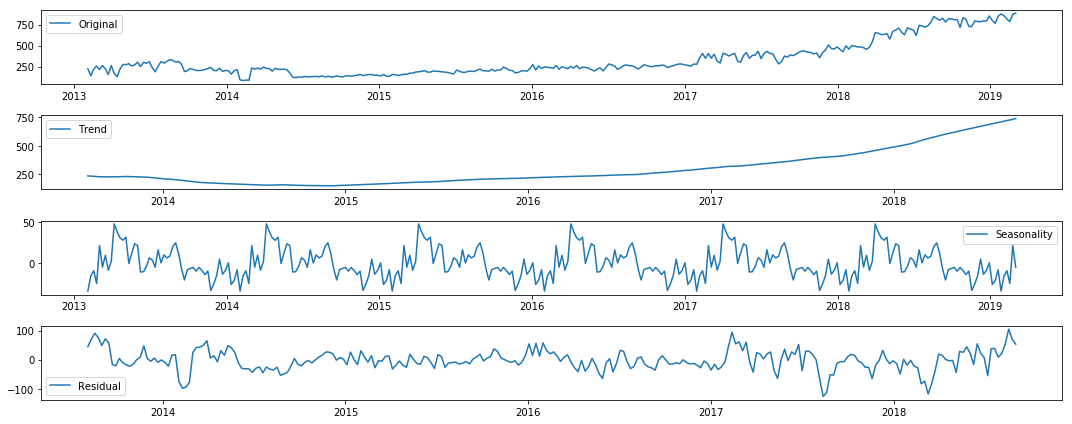

In [56]:
seasonal_decomposition(data.ts)

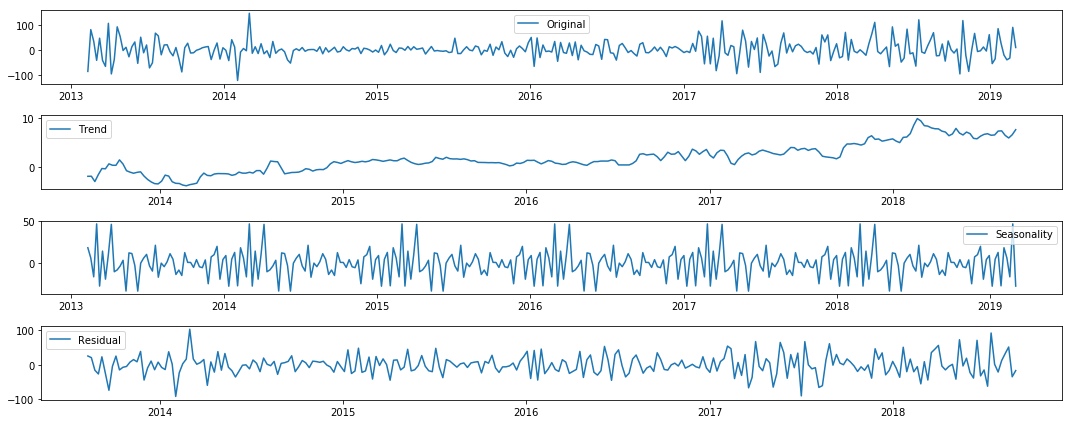

In [57]:
seasonal_decomposition(data.first_difference)

# Identification

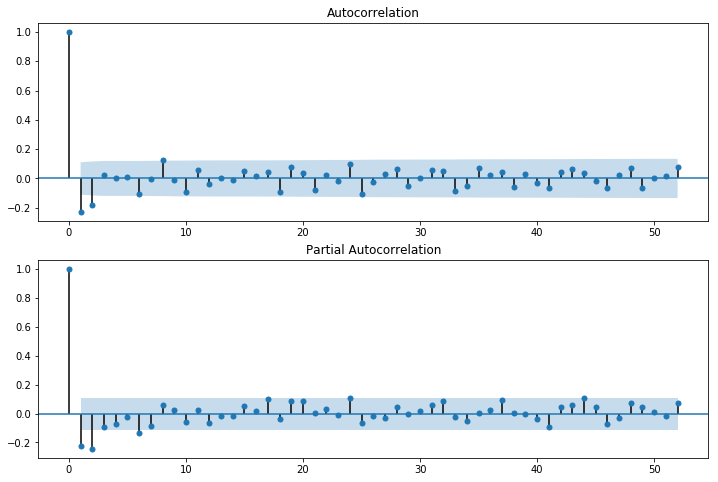

In [65]:
# Note: You must take data from 2nd-observation-on because we took first-difference in the original definition
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.first_difference.iloc[2:], lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data.first_difference.iloc[2:], lags=52, ax=ax2)


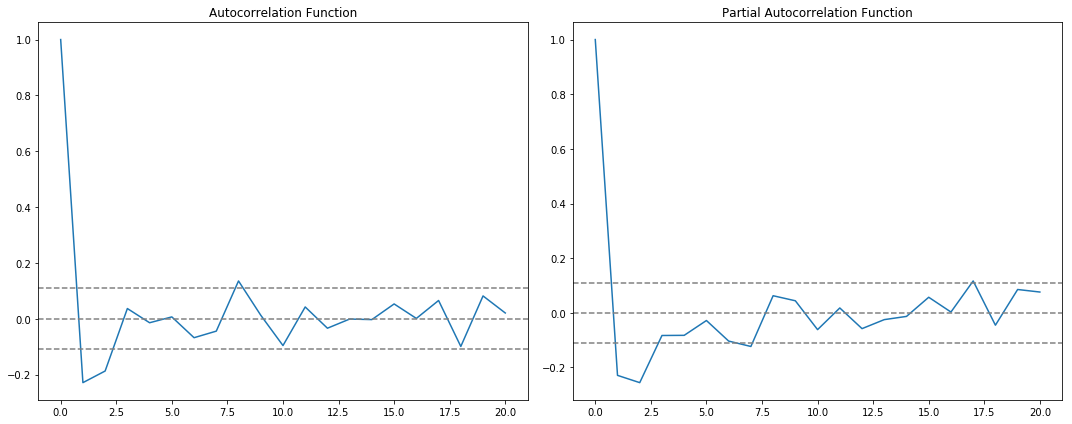

In [62]:
acf_pacf_plot(data.first_difference)

## Identify the AR portion of the specification

                             ARIMA Model Results                              
Dep. Variable:     D.first_difference   No. Observations:                  316
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1646.247
Method:                       css-mle   S.D. of innovations             44.230
Date:                Sun, 17 Mar 2019   AIC                           3300.493
Time:                        16:08:02   BIC                           3315.516
Sample:                    02-17-2013   HQIC                          3306.495
                         - 03-03-2019                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0997      1.115      0.089      0.929      -2.085       2.285
ar.L1.D.first_difference    -0.7638      0.050    -15.180      0.000      -0.862      -0.

C:\Users\a1000391\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
C:\Users\a1000391\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
C:\Users\a1000391\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1026: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\a1000391\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1029: FutureWarning: Using a non-tuple sequence 

Text(0.5,1,'RSS: nan')

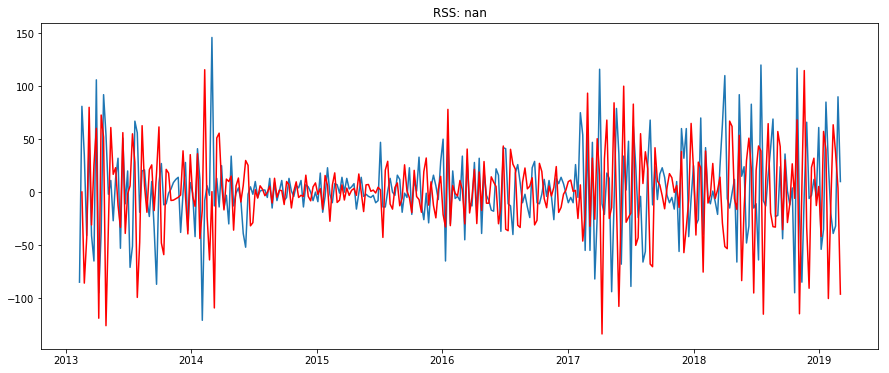

In [71]:
#AR Model
model = ARIMA(data.first_difference, order=(2,1,0))
results_AR = model.fit(disp=-1)
print(results_AR.summary())
plt.plot(data.first_difference)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-data.first_difference)**2))


## Identify the MA portion of the specification

                             ARIMA Model Results                              
Dep. Variable:     D.first_difference   No. Observations:                  316
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1594.793
Method:                       css-mle   S.D. of innovations             37.292
Date:                Sun, 17 Mar 2019   AIC                           3195.586
Time:                        16:13:03   BIC                           3206.854
Sample:                    02-17-2013   HQIC                          3200.088
                         - 03-03-2019                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0268      0.023      1.172      0.242      -0.018       0.072
ma.L1.D.first_difference    -1.0000      0.008   -126.320      0.000      -1.015      -0.

C:\Users\a1000391\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
C:\Users\a1000391\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: nan')

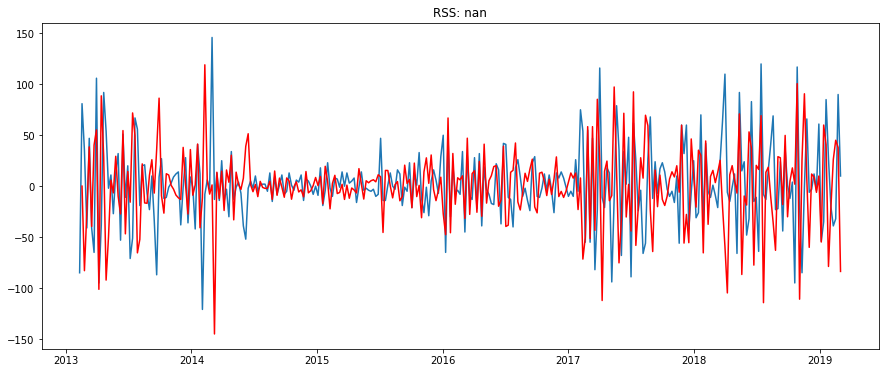

In [79]:
#MA Model
model = ARIMA(data.first_difference, order=(0,1,1))
results_MA = model.fit(disp=-1)
print(results_MA.summary())
plt.plot(data.first_difference)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-data.first_difference)**2))


C:\Users\a1000391\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
C:\Users\a1000391\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:     D.first_difference   No. Observations:                  316
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1574.997
Method:                       css-mle   S.D. of innovations             34.967
Date:                Sun, 17 Mar 2019   AIC                           3159.994
Time:                        16:14:04   BIC                           3178.773
Sample:                    02-17-2013   HQIC                          3167.496
                         - 03-03-2019                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0249      0.014      1.802      0.072      -0.002       0.052
ar.L1.D.first_difference    -0.2936      0.055     -5.380      0.000      -0.401      -0.

Text(0.5,1,'RSS: nan')

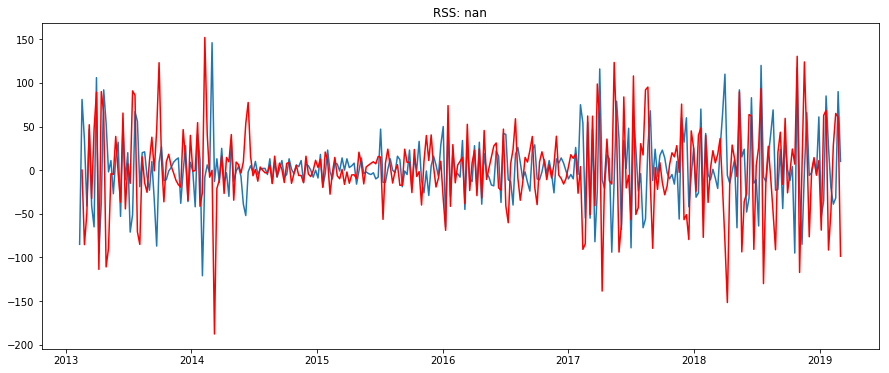

In [80]:
#Combined Model
model = ARIMA(data.first_difference, order=(2,1,1))
results_ARIMA = model.fit(disp=-1)
print(results_ARIMA.summary())
plt.plot(data.first_difference)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-data.first_difference)**2))
